# Image Classification (MNIST)
 

### Imports

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


### 1 MNIST dataset



In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# dataset loader
batch_size = 100
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

### 2 CNN model
* Input (입력의 형태)
  + Input type: torch.Tensor
  + Input shape: (N x C x H x W) 
    - N: Batch size, C: # of channels, H: height, W: width
  + (?, 1, 28, 28)
    - 여러장의, 흑백, 28x28 size의 이미지라고 가정하자
* Layer 설계
  + Layer 1
    - Conv2d >> C: 32, Kernel size (필터 크기): 3, Stride: 1, Padding: 1
    - ReLU
    - MaxPool >> Kernel size: 2, Stride: 2
    - 입-출력 (?, 1, 28, 28) >> (?, 32, 14, 14)
  + Layer 2
    - Conv2d >> C: 64, Kernel size (필터 크기): 3, Stride: 1, Padding: 1
    - ReLU
    - MaxPool >> Kernel size: 2, Stride: 2
    - 입-출력 (?, 32, 14, 14) >> (?, 64, 7, 7)
  + Layer 3
    - Linear >> input: 7x7x64 output: 10
    - Softmax

In [6]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 Input shape=(?, 1, 28, 28)
        #    Conv     -> (?, 32, 28, 28)
        #    Pool     -> (?, 32, 14, 14)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 Input shape=(?, 32, 14, 14)
        #    Conv      ->(?, 64, 14, 14)
        #    Pool      ->(?, 64, 7, 7)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 Linear 64x7x7 inputs -> 10 outputs
        self.fc = torch.nn.Linear(64*7*7, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

### 3 학습하기

In [7]:
# parameters
learning_rate = 0.001
training_epochs = 15

# contruct model
model = CNN().to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch:    1] cost = 0.225660458
[Epoch:    2] cost = 0.0629880354
[Epoch:    3] cost = 0.0461891703
[Epoch:    4] cost = 0.0373393372
[Epoch:    5] cost = 0.0313782692
[Epoch:    6] cost = 0.0260874033
[Epoch:    7] cost = 0.0217465069
[Epoch:    8] cost = 0.0183720477
[Epoch:    9] cost = 0.0160958134
[Epoch:   10] cost = 0.0135654686
[Epoch:   11] cost = 0.00985093694
[Epoch:   12] cost = 0.0104970988
[Epoch:   13] cost = 0.00752778538
[Epoch:   14] cost = 0.00586294848
[Epoch:   15] cost = 0.00733490475
Learning Finished!


In [8]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.targets.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9860999584197998


Label:  5
Prediction:  5


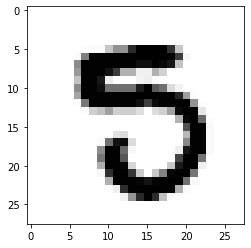

In [16]:
# Random sample test
with torch.no_grad():
  r = random.randint(0, len(mnist_test) - 1)
  img_sample = mnist_test.data[r].view(1, 1, 28, 28).float().to(device)
  label_sample = mnist_test.targets[r].to(device)

  print('Label: ', label_sample.item())
  sample_prediction = model(img_sample)
  print('Prediction: ', torch.argmax(sample_prediction, axis=1).item())

  plt.imshow(mnist_test.data[r].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()

### 3 Assignment
### 다음 미완성 코드를 활용해 새로운 data를 학습해보자
* Training data image 
  + Shape: (?, 3, 64, 128)
    - 여러장의, RGB, 64x128 size의 이미지라고 가정하자
* Test data image
  + Shape: (?, 3, ?, ?)
    - 여러장의, RGB, size를 알 수 없는 이미지라고 가정하자
* Labels
  + image의 class는 2가지 이다
  + data folder의 구성을 참고하자
* Data folder 위치
  + 노트북 github의 data folder 2개를 적당한 위치에 카피해 사용한다

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from google.colab import drive
drive.mount('/content/drive')

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Model
##### 지난 assignment에서 작성한 모델을 활용한다 
##### 바뀐 image input에 맞게 변형한다
##### 바뀐 image의 size는 64x128이며, 흑백이 아닌 RGB 3개의 채널임에 유의한다

# parameters
##### 적당히 수정한다
learning_rate = 
training_epochs = 

# contruct model
model = CNN().to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
##### 직접 dataset을 만들어 학습할 때 자주 사용되는 함수이니 기능을 숙지한다
##### pytorch 공식 홈페이지에서 관련 함수의 정보를 직접 찾아보는 것을 추천한다
trans = transforms.Compose([transforms.ToTensor()])
train_data = dsets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/courses/AI_Appl/train_data', transform=trans)
data_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True)

total_batch = len(data_loader)

##### 학습이 이루어지는 loop
##### 지난 source code를 그대로 사용해도 되지만, 연습삼아 직접 작성해보자

# test
##### 직접 dataset을 만들어 학습할 때 자주 사용되는 함수이니 기능을 숙지한다
##### pytorch 공식 홈페이지에서 관련 함수의 정보를 직접 찾아보는 것을 추천한다
trans=transforms.Compose([transforms.Resize((64,128)),transforms.ToTensor()])
test_data = dsets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/courses/AI_Appl/test_data', transform=trans)
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

with torch.no_grad():
##### 결과 test가 이루어지는 loop
##### 지난 source code를 그대로 사용해도 되지만, 연습삼아 직접 작성해보자


cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Learning started. It takes sometime.
[Epoch:    1] cost = 0.158599436
[Epoch:    2] cost = 0.00020430611
[Epoch:    3] cost = 2.68744279e-05
[Epoch:    4] cost = 5.39911434e-06
[Epoch:    5] cost = 1.20812297e-06
Learning Finished!
Accuracy: 1.0
